# Forecast Scheduling - Period Class

As described before on the Introduction, the `Period` class is the one that contains all the parameters to define the forecast models for the rest of the Wrappers (`Scenario`, `Well`, `WellsGroup`). 

In [1]:
from dcapy import dca
from dcapy.schedule import Period

import numpy as np 
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import seaborn as sns

## Create a dca Model

In [2]:
dec_model = dca.Arps(
    ti = date(2021,1,1),
    di = 0.3,
    freq_di = 'A',
    qi = [80,100],
    b = 0,
    fluid_rate = 250
)

#Create forecast
print(dec_model.forecast(start = date(2021,1,1), end=date(2021,6,1), freq_output='M'))

           oil_rate       oil_cum  iteration   oil_volume  fluid_rate  \
date                                                                    
2021-01   80.000000      0.000000          0  2448.672116       250.0   
2021-02   77.987393   2448.672116          0  2303.691934       250.0   
2021-03   76.213109   4607.383867          0  2245.736596       250.0   
2021-04   74.295771   6940.145308          0  2267.189892       250.0   
2021-05   72.486222   9141.763651          0  2210.152858       250.0   
2021-06   70.662643  11360.451023          0  2218.687372       250.0   
2021-01  100.000000      0.000000          1  3060.840145       250.0   
2021-02   97.484241   3060.840145          1  2879.614917       250.0   
2021-03   95.266386   5759.229834          1  2807.170745       250.0   
2021-04   92.869714   8675.181635          1  2833.987365       250.0   
2021-05   90.607777  11427.204563          1  2762.691072       250.0   
2021-06   88.328304  14200.563778          1  2773.

## Create a `Period` Instance

To create a `Period` Intance you have to provide a ``dca` model (either `Arps` or `Wor`), range dates and frequency output. These parameters are the same you would provide to generate a forecast by using only the dca model only. However, later in the notebook and next pages is shown what additional parameters can be defined when creating Period Instance.

The first way to create an instance is by providing the right key arguments. `Pydantic` is used to validate the input user.


### Example. Create instance

In [3]:
p1 = Period(
    name = 'Period-1',
    dca = dec_model,
    start = date(2021,1,1),
    end = date(2021,6,1),
    freq_output='M'
)

print(type(p1))

<class 'dcapy.schedule.schedule.Period'>


In [4]:
print(p1.json(exclude_unset=True, indent=2))

{
  "name": "Period-1",
  "dca": {
    "qi": [
      80.0,
      100.0
    ],
    "di": 0.3,
    "b": 0.0,
    "ti": "2021-01-01",
    "freq_di": "A",
    "fluid_rate": 250.0
  },
  "start": "2021-01-01",
  "end": "2021-06-01",
  "freq_output": "M"
}


### Wrong input passed

In [5]:

try:
    p1 = Period(
        name = 'Period-1',
        dca = 'string',
        start = date(2021,1,1),
        end = date(2021,6,1),
        freq_output='BM'
    )
except Exception as e:
    print(e)


3 validation errors for Period
dca
  value is not a valid dict (type=type_error.dict)
dca
  value is not a valid dict (type=type_error.dict)
freq_output
  value is not a valid enumeration member; permitted: 'A', 'M', 'D' (type=type_error.enum; enum_values=[<FreqEnum.A: 'A'>, <FreqEnum.M: 'M'>, <FreqEnum.D: 'D'>])


The wrong user input trigger the Pydantic validation error indicating the `dna` is not valid neither does `freq output`


Pydantic allows to create instances by passing a dictionary and it will validate even the deeper instances, for example the dca model

### Example create Period by passing dictionary

In [6]:
p1_dict = {
    'name':'Period-1',
    'dca': {
        'ti':'2021-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':[80,100],
        'b':0,
        'fluid_rate':250
    },
    'start':'2021-01-01',
    'end':'2022-01-01',
    'freq_output':'M'
}

p1 = Period(**p1_dict)

print(p1)

name='Period-1' cashflow_params=None cashflow=None forecast=None seed=None iter=1 ppf=None description=None key=None dca=Declination 
 Ti: 2021-01-01 
 Qi: [80.0, 100.0] bbl/d 
 Di: 0.3 A 
 b: 0.0 start=datetime.date(2021, 1, 1) end=datetime.date(2022, 1, 1) time_list=None freq_input='D' freq_output=<FreqEnum.M: 'M'> rate_limit=None cum_limit=None depends=None


It automatically validates dates even they are strings, floats and deeper instances like dca.Arps

If an input error is made on dca model the validator will also detect where is the mistake.

To generate the forecast of the period just call the method `generate_forecast`

In [7]:
print(p1.generate_forecast())

           oil_rate       oil_cum  iteration   oil_volume  fluid_rate  \
date                                                                    
2021-01   80.000000      0.000000          0  2448.672116       250.0   
2021-02   77.987393   2448.672116          0  2303.691934       250.0   
2021-03   76.213109   4607.383867          0  2245.736596       250.0   
2021-04   74.295771   6940.145308          0  2267.189892       250.0   
2021-05   72.486222   9141.763651          0  2210.152858       250.0   
2021-06   70.662643  11360.451023          0  2156.322329       250.0   
2021-07   68.941582  13454.408309          0  2102.074456       250.0   
2021-08   67.207178  15564.599934          0  2083.647957       250.0   
2021-09   65.516407  17621.704223          0  1999.281182       250.0   
2021-10   63.920689  19563.162298          0  1948.984085       250.0   
2021-11   62.312598  21519.672393          0  1901.514589       250.0   
2021-12   60.794911  23366.191475          0  1853.

### Add Rate limit

In [8]:
p1_dict = {
    'name':'Period-1',
    'dca': {
        'ti':'2021-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':[80,100],
        'b':0,
        'fluid_rate':250
    },
    'start':'2021-01-01',
    'end':'2022-01-01',
    'freq_output':'M',
    'rate_limit': 70
}

p1 = Period(**p1_dict)

print(p1.generate_forecast())

           oil_rate       oil_cum  iteration   oil_volume  fluid_rate  \
date                                                                    
2021-01   80.000000      0.000000          0  2448.672116       250.0   
2021-02   77.987393   2448.672116          0  2303.691934       250.0   
2021-03   76.213109   4607.383867          0  2245.736596       250.0   
2021-04   74.295771   6940.145308          0  2267.189892       250.0   
2021-05   72.486222   9141.763651          0  2210.152858       250.0   
2021-06   70.662643  11360.451023          0 -4570.881825       250.0   
2021-01  100.000000      0.000000          1  3060.840145       250.0   
2021-02   97.484241   3060.840145          1  2879.614917       250.0   
2021-03   95.266386   5759.229834          1  2807.170745       250.0   
2021-04   92.869714   8675.181635          1  2833.987365       250.0   
2021-05   90.607777  11427.204563          1  2762.691072       250.0   
2021-06   88.328304  14200.563778          1  2695.

In [9]:
### Probabilistic Variables


/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:245: RuntimeWarning: invalid value encountered in true_divide
  (np.power(qi / rate, b) - 1)/(b * di)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return qi/np.power(1+b*di*time_array,1/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:85: RuntimeWarning: divide by zero encountered in true_divide
  g = np.power(b*di*time_array+1,(b-1)/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:86: RuntimeWarning: divide by zero encountered in true_divide
  h = np.power(b*di*ti+1,(b-1)/b)


<AxesSubplot:xlabel='date', ylabel='oil_rate'>

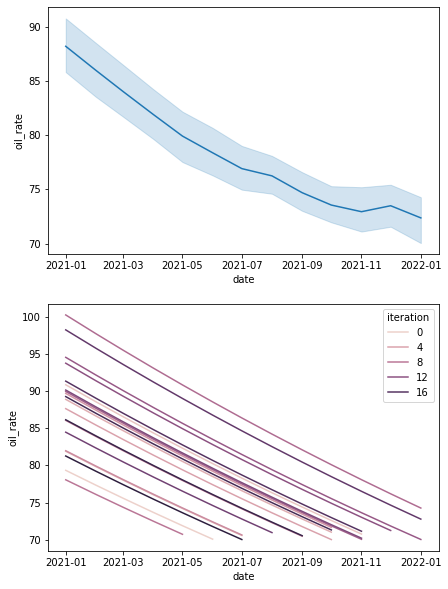

In [10]:
p1_dict = {
    'name':'Period-1',
    'dca': {
        'ti':'2021-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':{'dist':'norm','kw':{'loc':90, 'scale':10}},
        'b':0,
        'fluid_rate':250
    },
    'start':'2021-01-01',
    'end':'2022-01-01',
    'freq_output':'M',
    'rate_limit': 70,
    'iter':20
}

p1 = Period(**p1_dict)

prob_forecast = p1.generate_forecast()

fig, ax = plt.subplots(2,1, figsize=(7,10))
sns.lineplot(data=prob_forecast, x = prob_forecast.index.to_timestamp(), y='oil_rate', ax=ax[0])
sns.lineplot(data=prob_forecast, x = prob_forecast.index.to_timestamp(), y='oil_rate',hue='iteration', ax=ax[1])

## Add Cashflow Parameters

Adding Cashflow parameters is allowed with the purpose of creating a cashflow model for the period. 

The `Period` instance receive a list of `CashFlowParams` instances. That means you can add as many parameters as you want. 

To define a basic cashflow parameter you have to provide the next key-arguments:

1. Name for the cashflow
2. Value (single value, list of values, date-value pair, probabilistic variable or a Wiener Proccess)
3. Target (It defines if the resulting cashflow is income, capex or opex)
3. Multiply (It defines if the value must be multiplied by a given column of the forecast)

Let's define some cashflow parameters when creating a period:


In [11]:
p1cash_dict = {
    'name':'Period-1',
    'dca': {
        'ti':'2021-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':800,
        'b':0,
        'fluid_rate':250
    },
    'start':'2021-01-01',
    'end':'2022-01-01',
    'freq_output':'M',
    'rate_limit': 70,

    #Cashflow params keyword. It accept a list
    'cashflow_params':[
            {
                'name':'fix_opex',
                'value':-5000,       #Fix opex of U$ 5000 monthly
                'target':'opex',     #The cashflow generated is going to be an Opex in the cashflow model
                'freq_value':'M'     #The frequency of the value is in Months
            },
            {
                'name':'var_opex',
                'value':-12,    #Variable Opex 12 USD/bbl of oil
                'target':'opex', #The cashflow generated is going to be an Opex in the cashflow model
                'multiply':'oil_volume'  #Multiply the 12 USD/bbl by the oil_volume Column which is the monthly cumulative oil
            },
            {
                'name':'income',
                'value':60,             #Oil price 60 usd/bbl
                'target':'income',      #The cashflow generated is going to be an Income in the cashflow model
                'multiply':'oil_volume',  # Multiply the 60 USD/bbl by the oil_volume column
                'wi':0.9, #working Interest. In this case represent 10% royalties 
            },
            {
                'name':'capex_drill',
                'value':-3000000,             # 3 Million dollar of capex
                'target':'capex',      #The cashflow generated is going to be aCapex in the cashflow model
                'periods':1,  # repeat the value only one period
            }
        ]

}

p1_cash = Period(**p1cash_dict)

### Generate forecast

??? note
    Default working interest for a `CashFlowParameters` is 1

In [12]:
forecast = p1_cash.generate_forecast()
print(forecast)

           oil_rate        oil_cum  iteration    oil_volume  fluid_rate  \
date                                                                      
2021-01  800.000000       0.000000          0  24486.721159       250.0   
2021-02  779.873928   24486.721159          0  23036.919336       250.0   
2021-03  762.131092   46073.838672          0  22457.365959       250.0   
2021-04  742.957710   69401.453077          0  22671.898918       250.0   
2021-05  724.862217   91417.636508          0  22101.528575       250.0   
2021-06  706.626430  113604.510228          0  21563.223292       250.0   
2021-07  689.415822  134544.083091          0  21020.744556       250.0   
2021-08  672.071781  155645.999340          0  20836.479567       250.0   
2021-09  655.164075  176217.042226          0  19992.811818       250.0   
2021-10  639.206885  195631.622975          0  19489.840850       250.0   
2021-11  623.125980  215196.723927          0  19015.145887       250.0   
2021-12  607.949111  2336

### Generate a cashflow

When calling the `generate_cashflow` method it return a list of `CashFlowModel`

In [13]:
cf_model = p1_cash.generate_cashflow()

for i in cf_model:
    print(type(i))

<class 'dcapy.cashflow.cashflow.CashFlowModel'>


In [14]:
print(cf_model[0].fcf())

         income_Period-1  total_income  fix_opex_Period-1  var_opex_Period-1  \
2021-01     1.322283e+06  1.322283e+06            -5000.0     -293840.653906   
2021-02     1.243994e+06  1.243994e+06            -5000.0     -276443.032030   
2021-03     1.212698e+06  1.212698e+06            -5000.0     -269488.391508   
2021-04     1.224283e+06  1.224283e+06            -5000.0     -272062.787018   
2021-05     1.193483e+06  1.193483e+06            -5000.0     -265218.342905   
2021-06     1.164414e+06  1.164414e+06            -5000.0     -258758.679501   
2021-07     1.135120e+06  1.135120e+06            -5000.0     -252248.934673   
2021-08     1.125170e+06  1.125170e+06            -5000.0     -250037.754807   
2021-09     1.079612e+06  1.079612e+06            -5000.0     -239913.741813   
2021-10     1.052451e+06  1.052451e+06            -5000.0     -233878.090205   
2021-11     1.026818e+06  1.026818e+06            -5000.0     -228181.750639   
2021-12     1.000986e+06  1.000986e+06  

# Make a plot of the Cashflow Model

/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:359: UserWarning: FixedFormatter should only be used together with FixedLocator
  spax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks_cum])


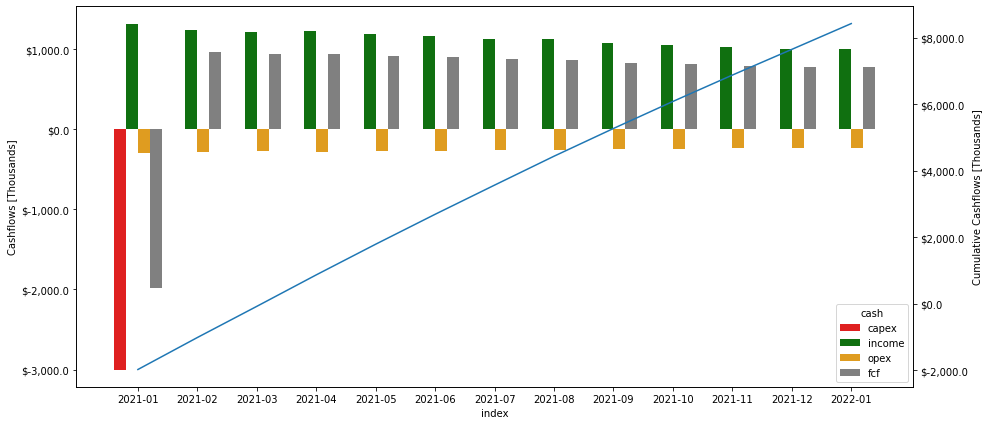

In [15]:
fig, ax= plt.subplots(figsize=(15,7))

cf_model[0].plot(cum=True, ax=ax)

In [16]:
## Estimate the NPV and IRR

In [17]:
p1_cash.npv([0.1,0.15], freq_rate='A', freq_cashflow='M')

,npv,iteration
0.007974,7.935376e+06,0
0.011715,7.712939e+06,0


In [18]:
p1_cash.irr()

,irr
0,0.466046


## Cashflow with Multiple Iterations

Whether you define multiple or Probabilistic variables when cashflow parameters are defined for the `Period` the same amount of cash flow models are generated as forecast iterations are.



In [19]:
p2cash_dict = {
    'name':'Period-1',
    'dca': {
        'ti':'2021-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':[800,700,500],
        'b':[0,0.5,1],
        'fluid_rate':250
    },
    'start':'2021-01-01',
    'end':'2022-01-01',
    'freq_output':'M',
    'rate_limit': 70,

    #Cashflow params keyword. It accept a list
    'cashflow_params':[
            {
                'name':'fix_opex',
                'value':-5000,       #Fix opex of U$ 5000 monthly
                'target':'opex',     #The cashflow generated is going to be an Opex in the cashflow model
                'freq_value':'M'     #The frequency of the value is in Months
            },
            {
                'name':'var_opex',
                'value':-12,    #Variable Opex 12 USD/bbl of oil
                'target':'opex', #The cashflow generated is going to be an Opex in the cashflow model
                'multiply':'oil_volume'  #Multiply the 12 USD/bbl by the oil_volume Column which is the monthly cumulative oil
            },
            {
                'name':'income',
                'value':60,             #Oil price 60 usd/bbl
                'target':'income',      #The cashflow generated is going to be an Income in the cashflow model
                'multiply':'oil_volume',  # Multiply the 60 USD/bbl by the oil_volume column
                'wi':0.9, #working Interest. In this case represent 10% royalties 
            },
            {
                'name':'capex_drill',
                'value':-3000000,             # 3 Million dollar of capex
                'target':'capex',      #The cashflow generated is going to be aCapex in the cashflow model
                'periods':1,  # repeat the value only one period
            }
        ]

}

p2_cash = Period(**p2cash_dict)

p2_forecast = p2_cash.generate_forecast()
p2_cashflow = p2_cash.generate_cashflow()



/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:245: RuntimeWarning: invalid value encountered in true_divide
  (np.power(qi / rate, b) - 1)/(b * di)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return qi/np.power(1+b*di*time_array,1/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:84: RuntimeWarning: divide by zero encountered in true_divide
  f = qi/(di*(b-1))
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:85: RuntimeWarning: divide by zero encountered in true_divide
  g = np.power(b*di*time_array+1,(b-1)/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:86: RuntimeWarning: divide by zero encountered in true_divide
  h = np.power(b*di*ti+1,(b-1)/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:87: RuntimeWarning: invalid value encountered in multiply
  return f*(g-h)


/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:359: UserWarning: FixedFormatter should only be used together with FixedLocator
  spax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks_cum])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:359: UserWarning: FixedFormatter should only be used together with FixedLocator
  spax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks_cum])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should on

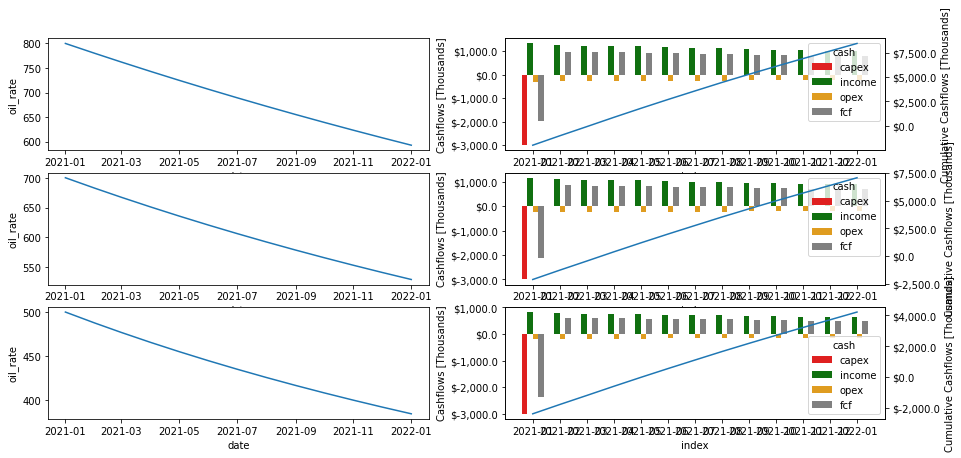

In [20]:
n_cashflows = len(p2_cashflow)

fig, ax= plt.subplots(n_cashflows,2,figsize=(15,7))

for i in range(n_cashflows):
    forecast_iteration = p2_forecast[p2_forecast['iteration']==i] 
    sns.lineplot(data =forecast_iteration, x=forecast_iteration.index.to_timestamp(), y='oil_rate', ax=ax[i,0])
    p2_cashflow[i].plot(cum=True, ax=ax[i,1])

In [21]:
p2_cash.npv([0.1,0.17], freq_rate='A', freq_cashflow='M')

,npv,iteration
0.007974,7.935376e+06,0
0.013170,7.628429e+06,0
0.007974,6.622938e+06,1
0.013170,6.351756e+06,1
0.007974,3.895086e+06,2
0.013170,3.700136e+06,2


## Multiple Cashflow Params

Cashflow parameters values can also be evaluated with multiple iterations. 

??? note
    When creating multiple iterations either on dca or cashflow parameters, the number of iterations must be the same in other to create element-wise models. 

In [22]:
p3cash_dict = {
    'name':'Period-1',
    'dca': {
        'ti':'2021-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':700,
        'b':0,
        'fluid_rate':250
    },
    'start':'2021-01-01',
    'end':'2022-01-01',
    'freq_output':'M',
    'rate_limit': 70,

    #Cashflow params keyword. It accept a list
    'cashflow_params':[
            {
                'name':'fix_opex',
                'value':-5000,       #Fix opex of U$ 5000 monthly
                'target':'opex',     #The cashflow generated is going to be an Opex in the cashflow model
                'freq_value':'M'     #The frequency of the value is in Months
            },
            {
                'name':'var_opex',
                'value':-12,    #Variable Opex 12 USD/bbl of oil
                'target':'opex', #The cashflow generated is going to be an Opex in the cashflow model
                'multiply':'oil_volume'  #Multiply the 12 USD/bbl by the oil_volume Column which is the monthly cumulative oil
            },
            {
                'name':'income',
                'value':[20,30,40,60,80],             #Oil price 60 usd/bbl
                'target':'income',      #The cashflow generated is going to be an Income in the cashflow model
                'multiply':'oil_volume',  # Multiply the 60 USD/bbl by the oil_volume column
                'wi':0.9, #working Interest. In this case represent 10% royalties 
            },
            {
                'name':'capex_drill',
                'value':-3000000,             # 3 Million dollar of capex
                'target':'capex',      #The cashflow generated is going to be aCapex in the cashflow model
                'periods':1,  # repeat the value only one period
            }
        ]

}
p3_cash = Period(**p3cash_dict)

p3_forecast = p3_cash.generate_forecast()
p3_cashflow = p3_cash.generate_cashflow()

/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:245: RuntimeWarning: invalid value encountered in true_divide
  (np.power(qi / rate, b) - 1)/(b * di)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:68: RuntimeWarning: divide by zero encountered in true_divide
  return qi/np.power(1+b*di*time_array,1/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:85: RuntimeWarning: divide by zero encountered in true_divide
  g = np.power(b*di*time_array+1,(b-1)/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:86: RuntimeWarning: divide by zero encountered in true_divide
  h = np.power(b*di*ti+1,(b-1)/b)


/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:359: UserWarning: FixedFormatter should only be used together with FixedLocator
  spax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks_cum])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:359: UserWarning: FixedFormatter should only be used together with FixedLocator
  spax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks_cum])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:351: UserWarning: FixedFormatter should on

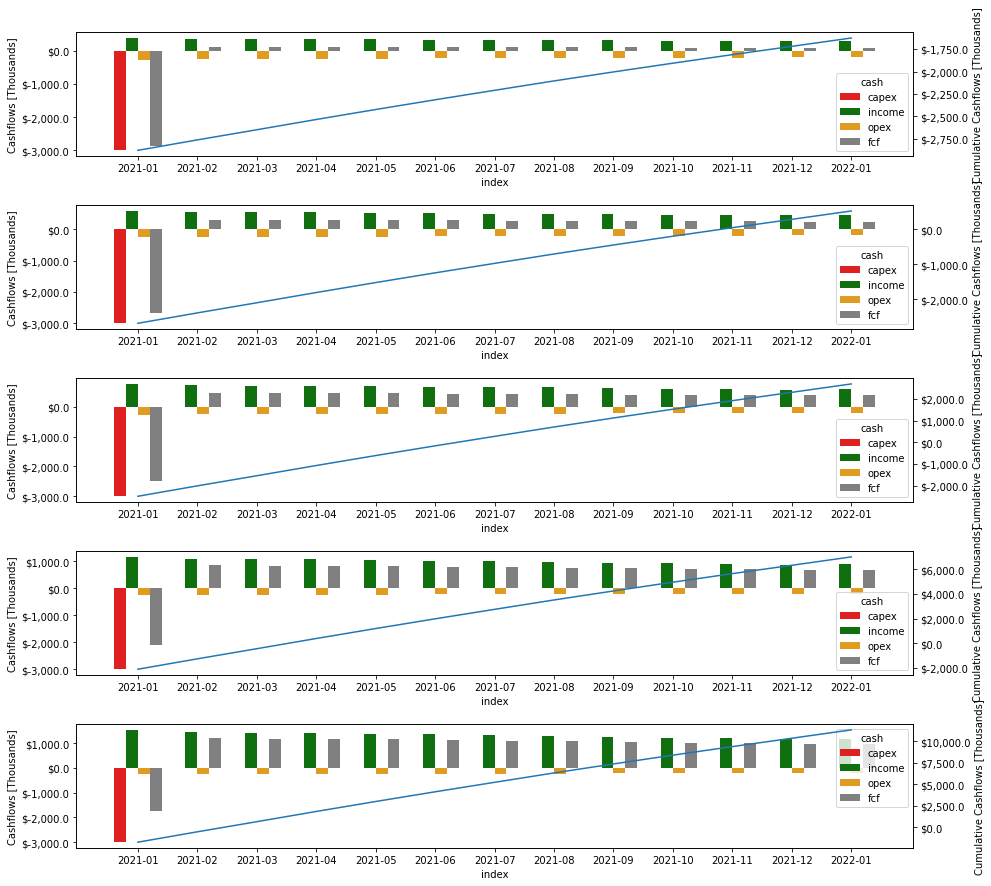

In [23]:
n_cashflows = len(p3_cashflow)

fig, ax= plt.subplots(n_cashflows,1,figsize=(15,15), gridspec_kw={'hspace':0.4})

for i in range(n_cashflows):
    p3_cashflow[i].plot(cum=True, ax=ax[i])

Here, the same forecast was used to create five different cashflow models according with the iterations defined on the Oil price

In [24]:
p3_cash.npv([0.1], freq_rate='A', freq_cashflow='M')

,npv,iteration
0.007974,-1.687330e+06,0
0.007974,3.746782e+05,1
0.007974,2.436687e+06,2
0.007974,6.560703e+06,3
0.007974,1.068472e+07,4


## Export the model

All classes in `dcapy` are based on Pydantic, hence they can be directly exported to a dictionary, json and further to yml

#### Export to Dictionary

In [25]:
print(p3_cash.dict(exclude={'forecast','cashflow'}, exclude_unset=True))

{'name': 'Period-1', 'cashflow_params': [{'name': 'fix_opex', 'value': -5000.0, 'target': <TargetEnum.opex: 'opex'>, 'freq_value': <FreqEnum.M: 'M'>}, {'name': 'var_opex', 'value': -12.0, 'target': <TargetEnum.opex: 'opex'>, 'multiply': 'oil_volume'}, {'name': 'income', 'wi': 0.9, 'value': [20.0, 30.0, 40.0, 60.0, 80.0], 'target': <TargetEnum.income: 'income'>, 'multiply': 'oil_volume'}, {'name': 'capex_drill', 'periods': 1, 'value': -3000000.0, 'target': <TargetEnum.capex: 'capex'>}], 'dca': {'qi': 700.0, 'di': 0.3, 'b': 0.0, 'ti': datetime.date(2021, 1, 1), 'freq_di': <FreqEnum.A: 'A'>, 'fluid_rate': 250.0}, 'start': datetime.date(2021, 1, 1), 'end': datetime.date(2022, 1, 1), 'freq_output': <FreqEnum.M: 'M'>, 'rate_limit': 70.0}


#### Export to json

In [26]:
print(p3_cash.json(exclude={'forecast','cashflow'}, exclude_unset=True))

{"name": "Period-1", "cashflow_params": [{"name": "fix_opex", "value": -5000.0, "target": "opex", "freq_value": "M"}, {"name": "var_opex", "value": -12.0, "target": "opex", "multiply": "oil_volume"}, {"name": "income", "wi": 0.9, "value": [20.0, 30.0, 40.0, 60.0, 80.0], "target": "income", "multiply": "oil_volume"}, {"name": "capex_drill", "periods": 1, "value": -3000000.0, "target": "capex"}], "dca": {"qi": 700.0, "di": 0.3, "b": 0.0, "ti": "2021-01-01", "freq_di": "A", "fluid_rate": 250.0}, "start": "2021-01-01", "end": "2022-01-01", "freq_output": "M", "rate_limit": 70.0}


In [27]:
p3_cash.tree()

📉Period-1                                                                                   

#### Export to cloud

Dcapy has integrated connection with an API hosted on [Deta](https://deta.sh) that allows to save your models on the cloud. This allows you to create, update and delete your models on a remote database whicgh is accesible throught a single account (with Oauth2 Authentication).